In [142]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, MaxAbsScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import mylib as my

df = pd.read_csv('diabetes.csv')
print(df.isna().sum()) #No NaN values
print((df == 0).sum()) #Several 0 values, this data is important, fill with the median
#df.shape 768 Rows, 9 Columns

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [143]:
columns_replace= ['BloodPressure', 'Glucose', 'SkinThickness', 'Insulin', 'BMI'] #These columns should never have 0 (NULL)

for column in columns_replace :
   me= int(df[column].mean(skipna=True))
   df[column] = df[column].replace(0,me)
print((df == 0).sum()) #cleaned up

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


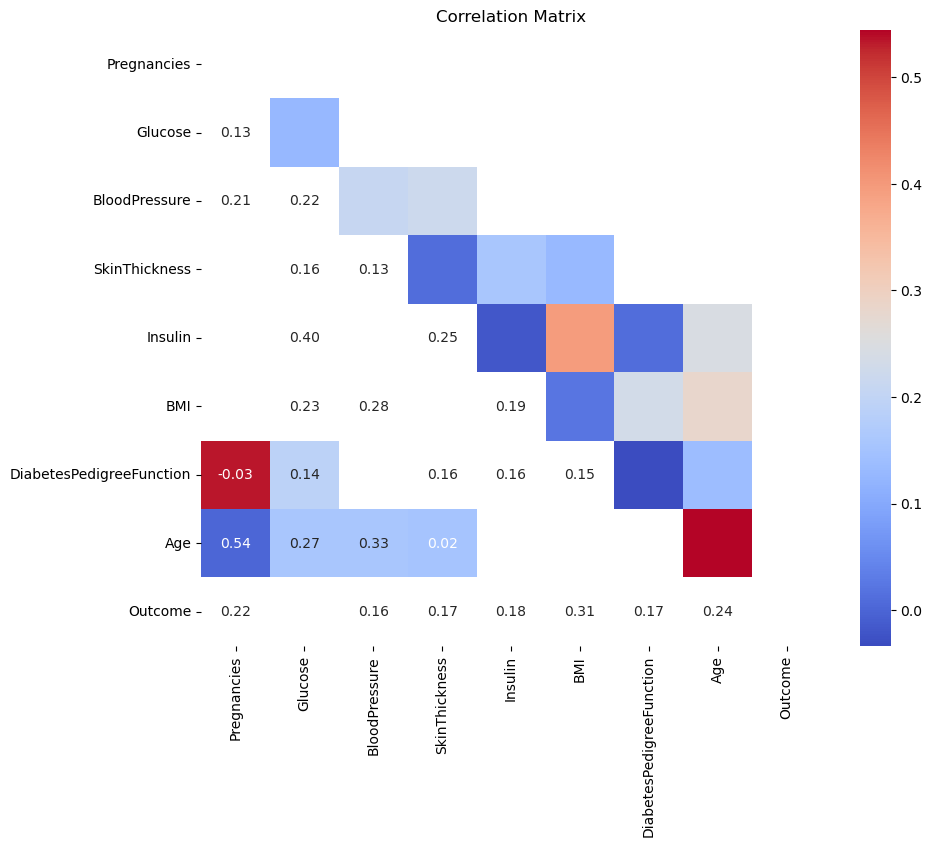

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot the heatmap of the correlation matrix with the mask
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Correlation Matrix')
plt.show()

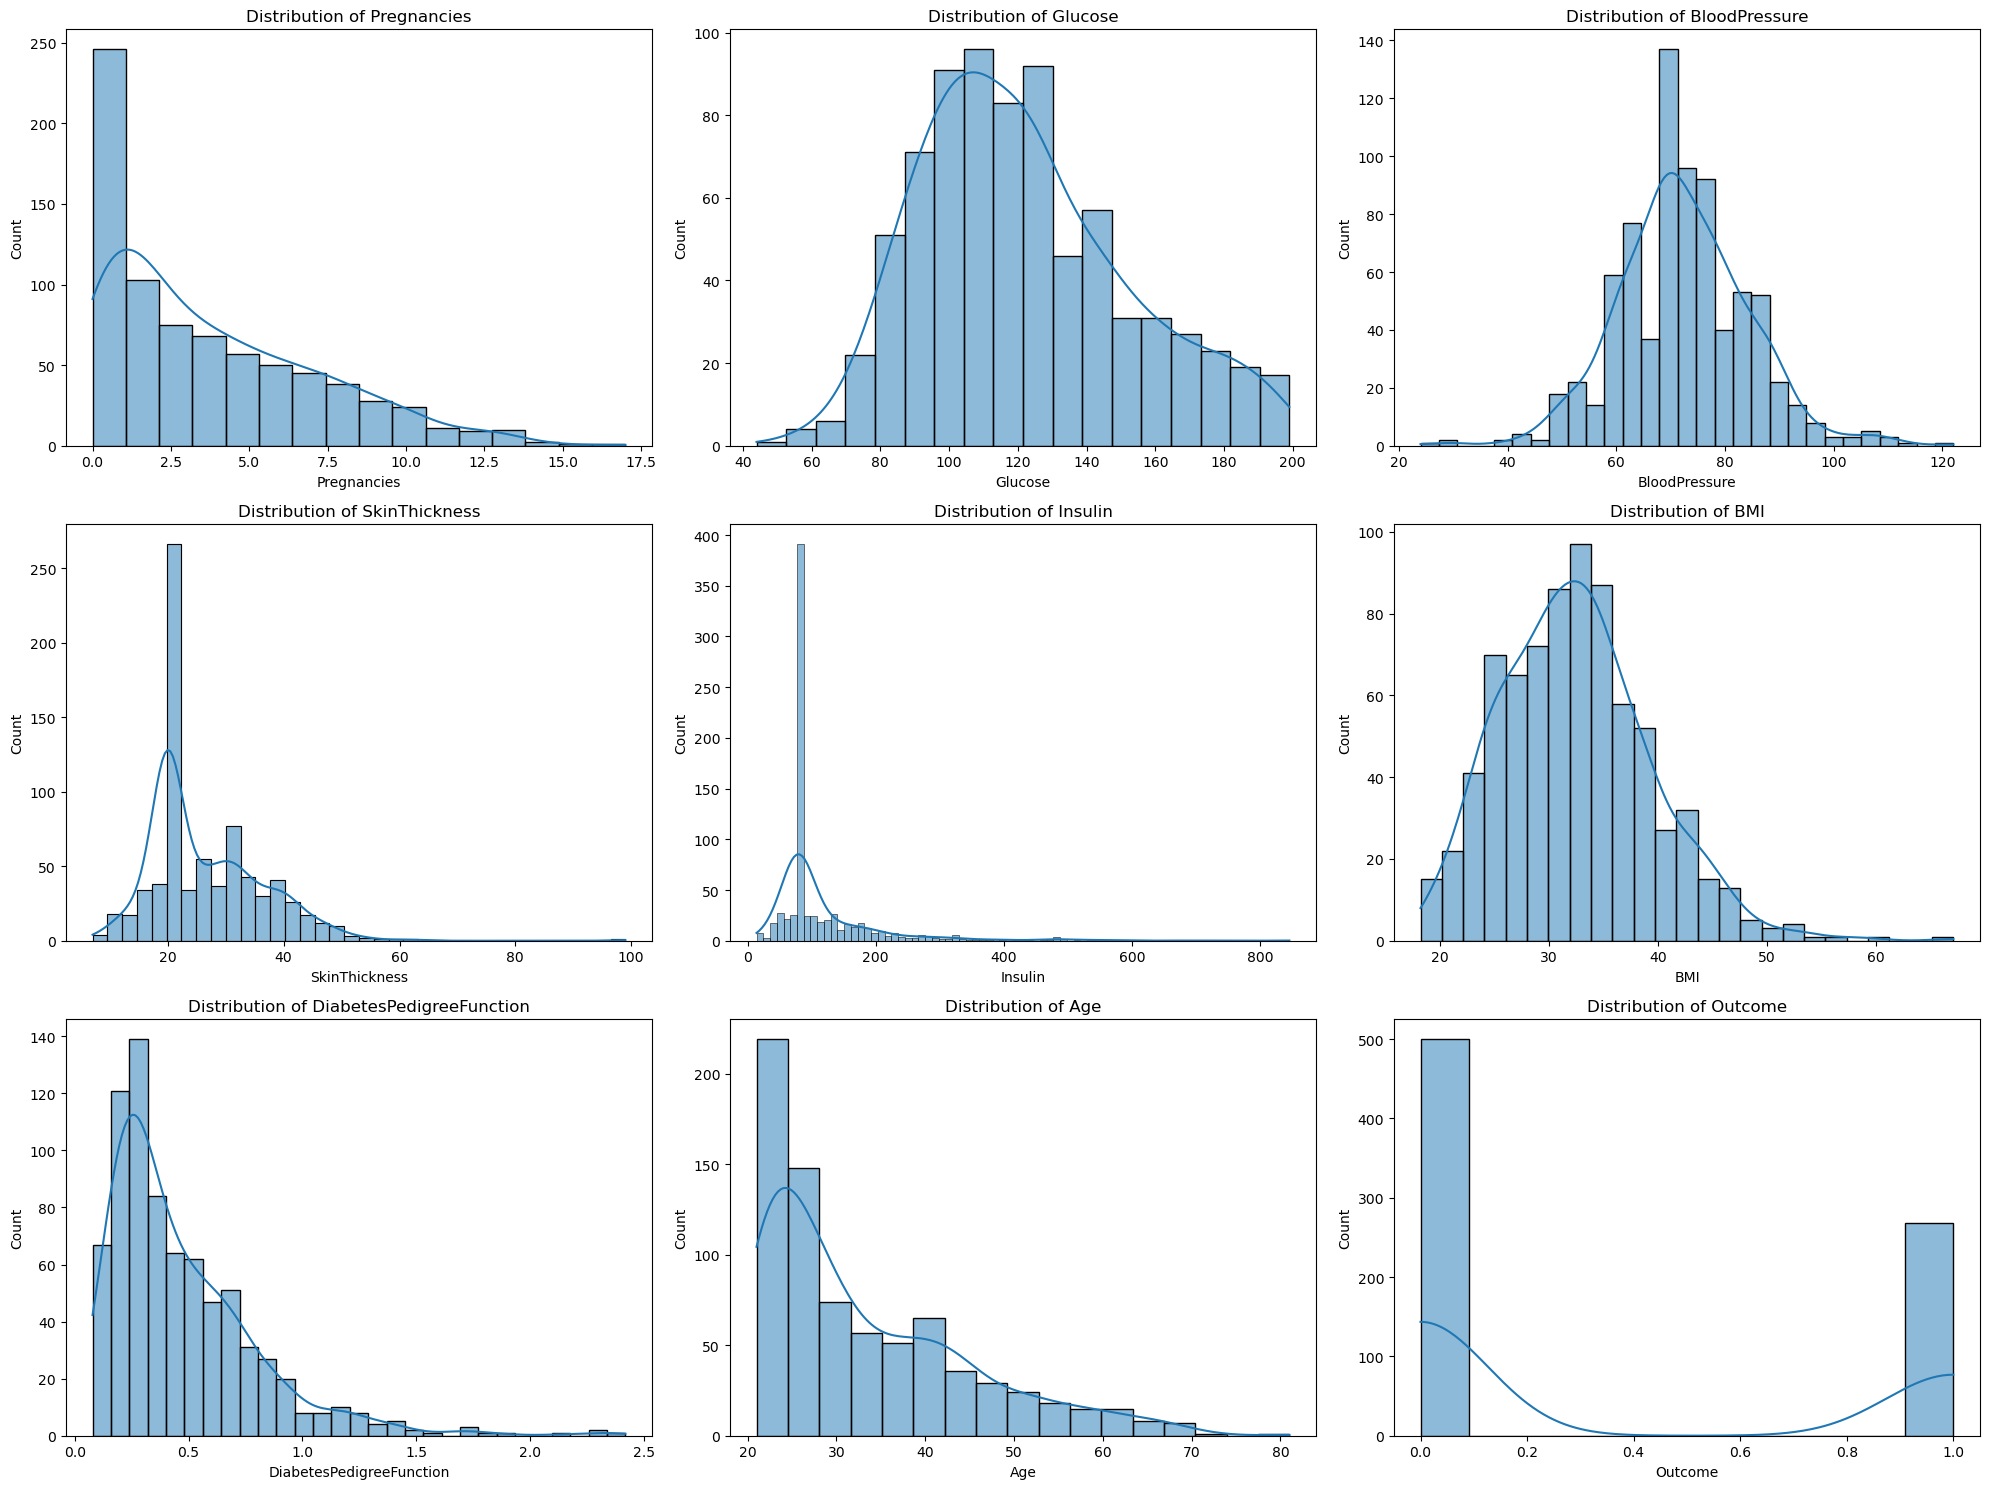

In [145]:
plt.figure(figsize=(20, 15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)  # Adjust the number of rows and columns based on the number of features
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

**Feature Vectorization**

In [146]:
###Feature Vectorization
print(df.info()) #All data is already numerical or encoded properly

print(df.describe().T) #Data has varying scales, we need to normalize it
diabetes_df = df.copy()
df = df.drop(columns=['SkinThickness', 'Insulin'])

X, y = df.iloc[:,:-1], df.iloc[:, -1]

# Scale the input features
X_normal = StandardScaler().fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
                          count        mean        std     min       25%  \
Pregnancies               768.0    3.845052   3.369578   0.000   1.00000   
Glucose                   768.0  121.675781  30.436252  44.000  99.75000   
BloodPr

**Anomaly Detection: Outliers**

In [147]:
### Outlier Check:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(contamination=0.05).fit(X_normal)

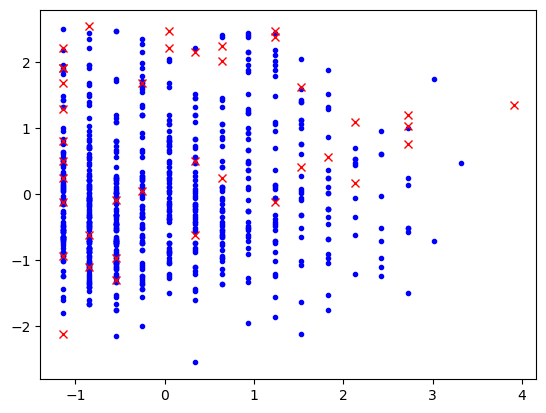

In [148]:
predictions = iforest.predict(X_normal)
# Plot the normal points
plt.plot(X_normal[predictions == 1][:, 0], X_normal[predictions == 1][:, 1], 'b.')

# Plot the anomalous points
plt.plot(X_normal[predictions == -1][:, 0], X_normal[predictions == -1][:, 1], 'rx')

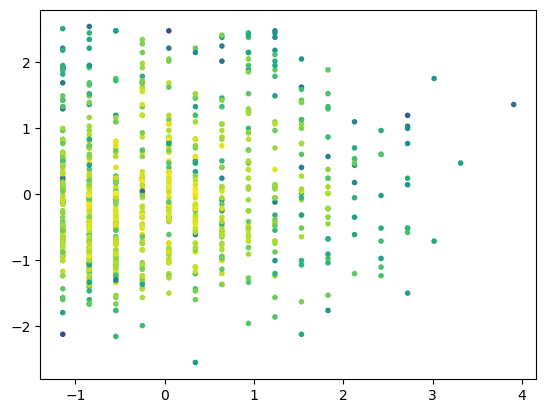

In [149]:
plt.scatter(X_normal[:, 0], X_normal[:, 1], c=iforest.decision_function(X_normal), marker='.')

In [150]:
dfo = pd.DataFrame(dict(predicted_label=iforest.predict(X_normal), score=iforest.decision_function(X_normal)))
outliers = dfo[dfo['predicted_label'] == -1].values
inliers = dfo[dfo['predicted_label'] == 1].head(len(outliers)).values
outliers_df = pd.DataFrame(np.concatenate([inliers, outliers], axis=1), 
             columns=['Inlier Label', 'Inline Score', 'Outlier Label', 'Outline Score'])
outliers_df = outliers_df.sort_values(by='Outline Score', ascending=True)
print(outliers_df.head())


    Inlier Label  Inline Score  Outlier Label  Outline Score
21           1.0      0.035709           -1.0      -0.168431
0            1.0      0.122551           -1.0      -0.127254
11           1.0      0.028718           -1.0      -0.097911
27           1.0      0.121657           -1.0      -0.093004
16           1.0      0.148072           -1.0      -0.086042


Ultimatly none of these outliers are significant enough to remove, they are each very low

**Dimensionality Reduction: PCA**

In [151]:
pca_normalized = PCA(n_components=2).fit(X_normal)
pca_raw = PCA(n_components=2).fit(X)

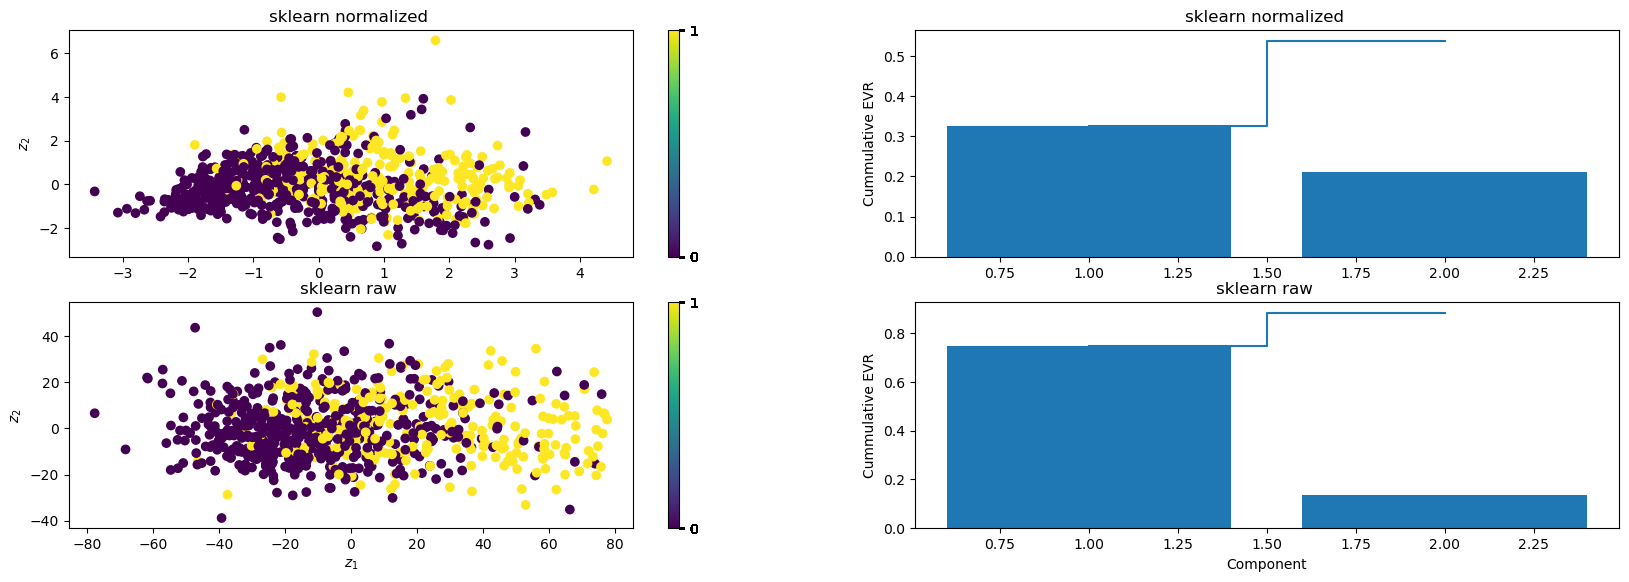

In [152]:
fig = plt.figure(figsize=(20, 10))

for i, pca, title in [(1, pca_normalized, "sklearn normalized "), 
                      (3, pca_raw, "sklearn raw ")]:
    X_projected = pca.transform(X_normal if i < 3 else X)

    plt.subplot(3, 2, i)
    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y)
    cb = plt.colorbar()
    cb.set_ticks(y)
    if i != 1: plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.title(title)

    expl_var = pca.explained_variance_ratio_
    cum_expl_var = np.cumsum(expl_var)

    plt.subplot(3, 2, i + 1)
    plt.bar(range(1, len(expl_var) + 1), expl_var, align='center')
    plt.ylabel('EVR')
    if i != 1: plt.xlabel('Component')

    plt.step(range(1, len(cum_expl_var) + 1), cum_expl_var, where='mid')
    plt.ylabel("Cummulative EVR")
    if i != 1: plt.xlabel('Component')
    plt.title(title)

In [153]:
eigen_vals, eigen_vecs = np.linalg.eig(np.cov(X_normal.T))
loadings = eigen_vecs * np.sqrt(eigen_vals)

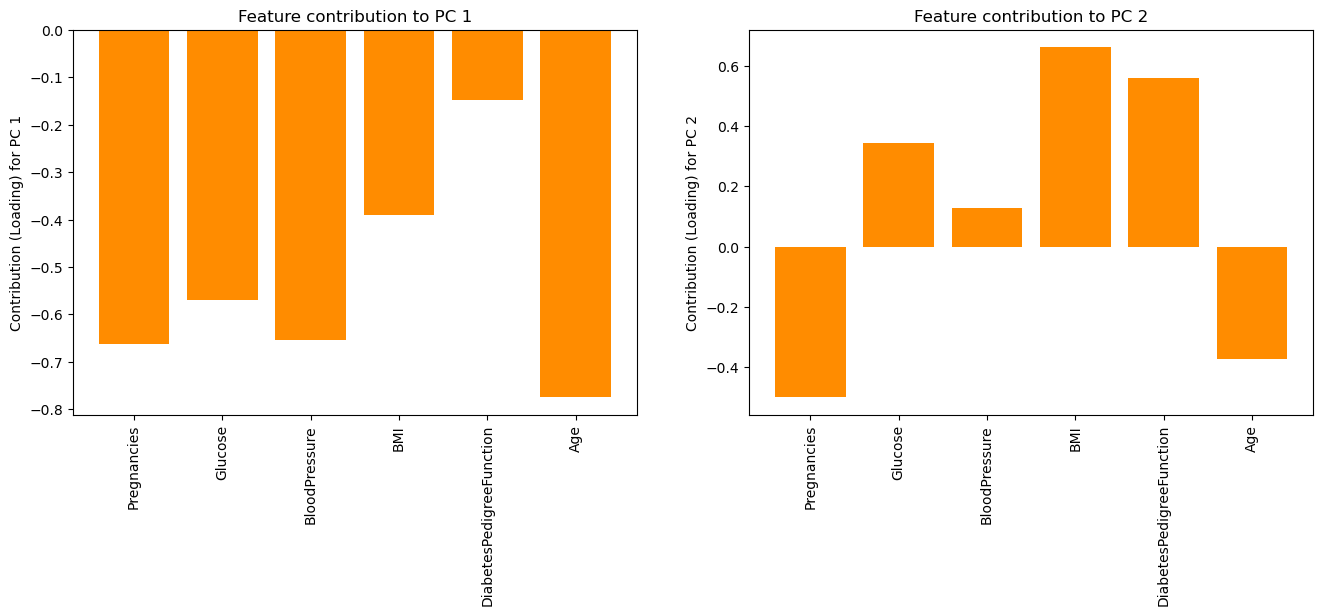

In [154]:
fig = plt.figure(figsize=(16, 5))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.bar(range(X_normal.shape[1]), loadings[:, i], align='center', color="darkorange")
    plt.ylabel(f"Contribution (Loading) for PC {i + 1}")
    plt.xticks(range(6), labels=df.columns[:-1], rotation=90)
    plt.title(f"Feature contribution to PC {i + 1}")

**Additional PCA methods to see if there is a better way**

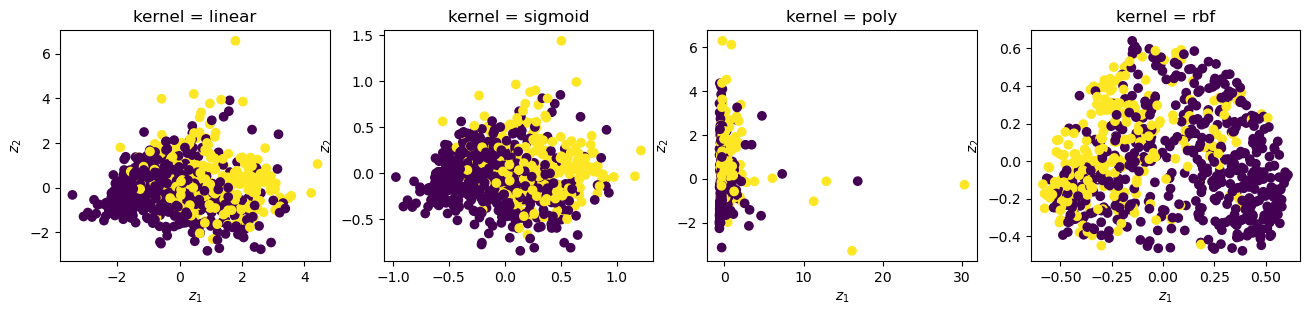

In [155]:
from sklearn.decomposition import KernelPCA
fig = plt.figure(figsize=(16, 3))

for i, k in enumerate(["linear", "sigmoid", "poly", "rbf"]):
    plt.subplot(1,4, i + 1)
    k_pca = KernelPCA(n_components=2, kernel=k)
    X_projected = k_pca.fit_transform(X_normal)
    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=y)
    if i != 1: plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.title(f"kernel = {k}")

**KMeans**

In [156]:
from sklearn.cluster import KMeans

X_pca = PCA(n_components=2).fit_transform(X_normal) #Use PCA to reduce the dimensionality of X

K = np.arange(2, 21)
models = [ KMeans(k).fit(X_pca) for k in K ]

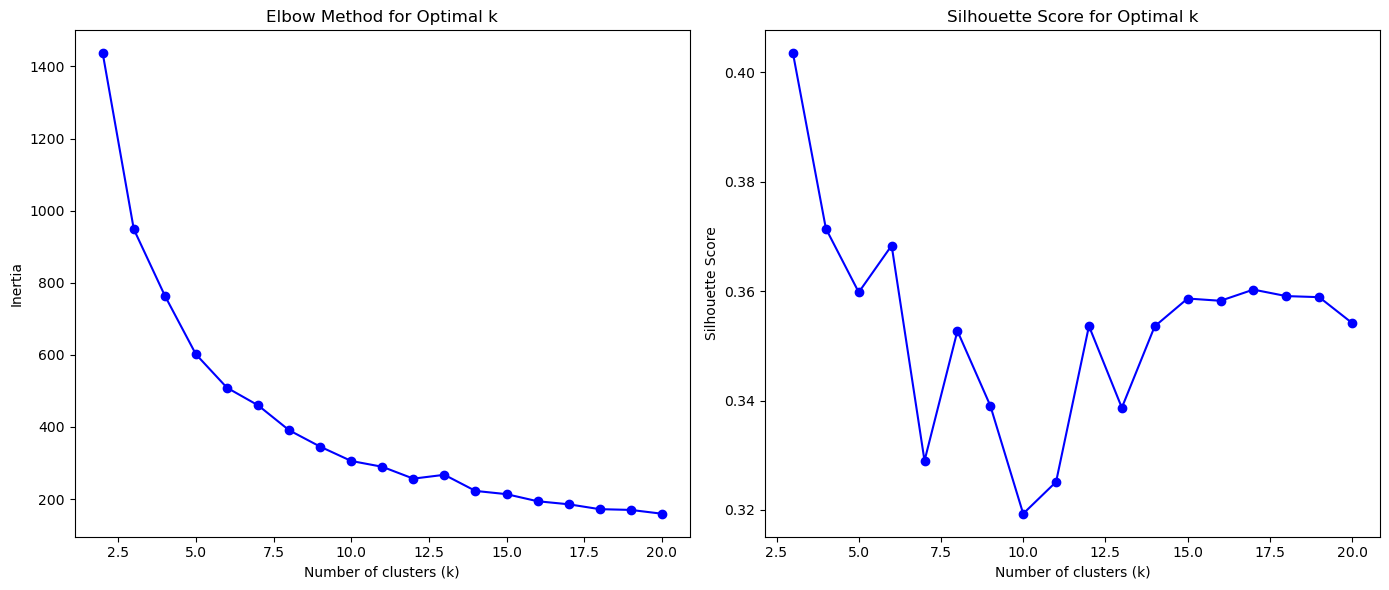

In [157]:
from sklearn.metrics import silhouette_score


# Elbow Method
inertia = [model.inertia_ for model in models]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Silhouette Score
silhouette_scores = []
for k in K[1:]:  # Silhouette score is not defined for k=1
    model = KMeans(n_clusters=k, random_state=0).fit(X_pca)
    labels = model.labels_
    silhouette_scores.append(silhouette_score(X_pca, labels))

plt.subplot(1, 2, 2)
plt.plot(K[1:], silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()

In [158]:
##Looks like 3 is my spot

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=3).fit(X_pca)
print(f"Inertia: {kmeans.inertia_}")
print(f"Silhouette Score: {silhouette_score(X_pca, kmeans.labels_)}")

Inertia: 948.3289777259523
Silhouette Score: 0.4031805865230164


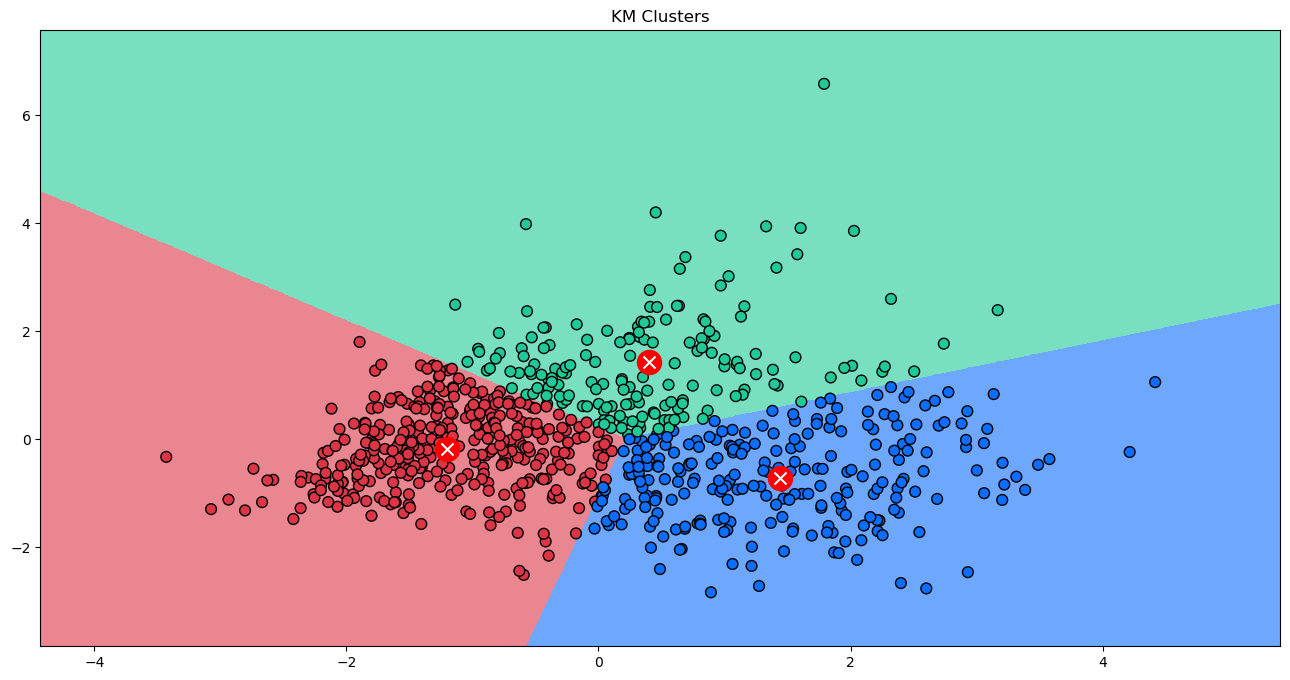

In [159]:
###Plot the KMeans

my.plot_decision_regions(X_pca, kmeans.predict(X_pca).reshape(len(X_pca), 1), kmeans, resolution=0.01, title="KM Clusters")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='o', s=300, facecolors='red', edgecolors='r', color='r')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c="w", marker="x", s=75)

In [160]:
from sklearn.metrics.cluster import normalized_mutual_info_score

print("KMeans:", normalized_mutual_info_score(y, kmeans.labels_))

KMeans: 0.10634055780190717


In [161]:
#Import required packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import mylib as my
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, ParameterSampler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, accuracy_score

Things to do:

Explore the data using descriptive statistics and visualizations to understand the data and explore correlations between its features.

Implement validation techniques like K-fold cross-validation

Logistic Regression, Decision Tree, SVM

Evaluate and report on the results of the best models

Organize steps using pipelines.

In [162]:
#Resetting df copy for use for supervised models 

diabetes_df = df.copy()


## Data Statistics and Visualizations

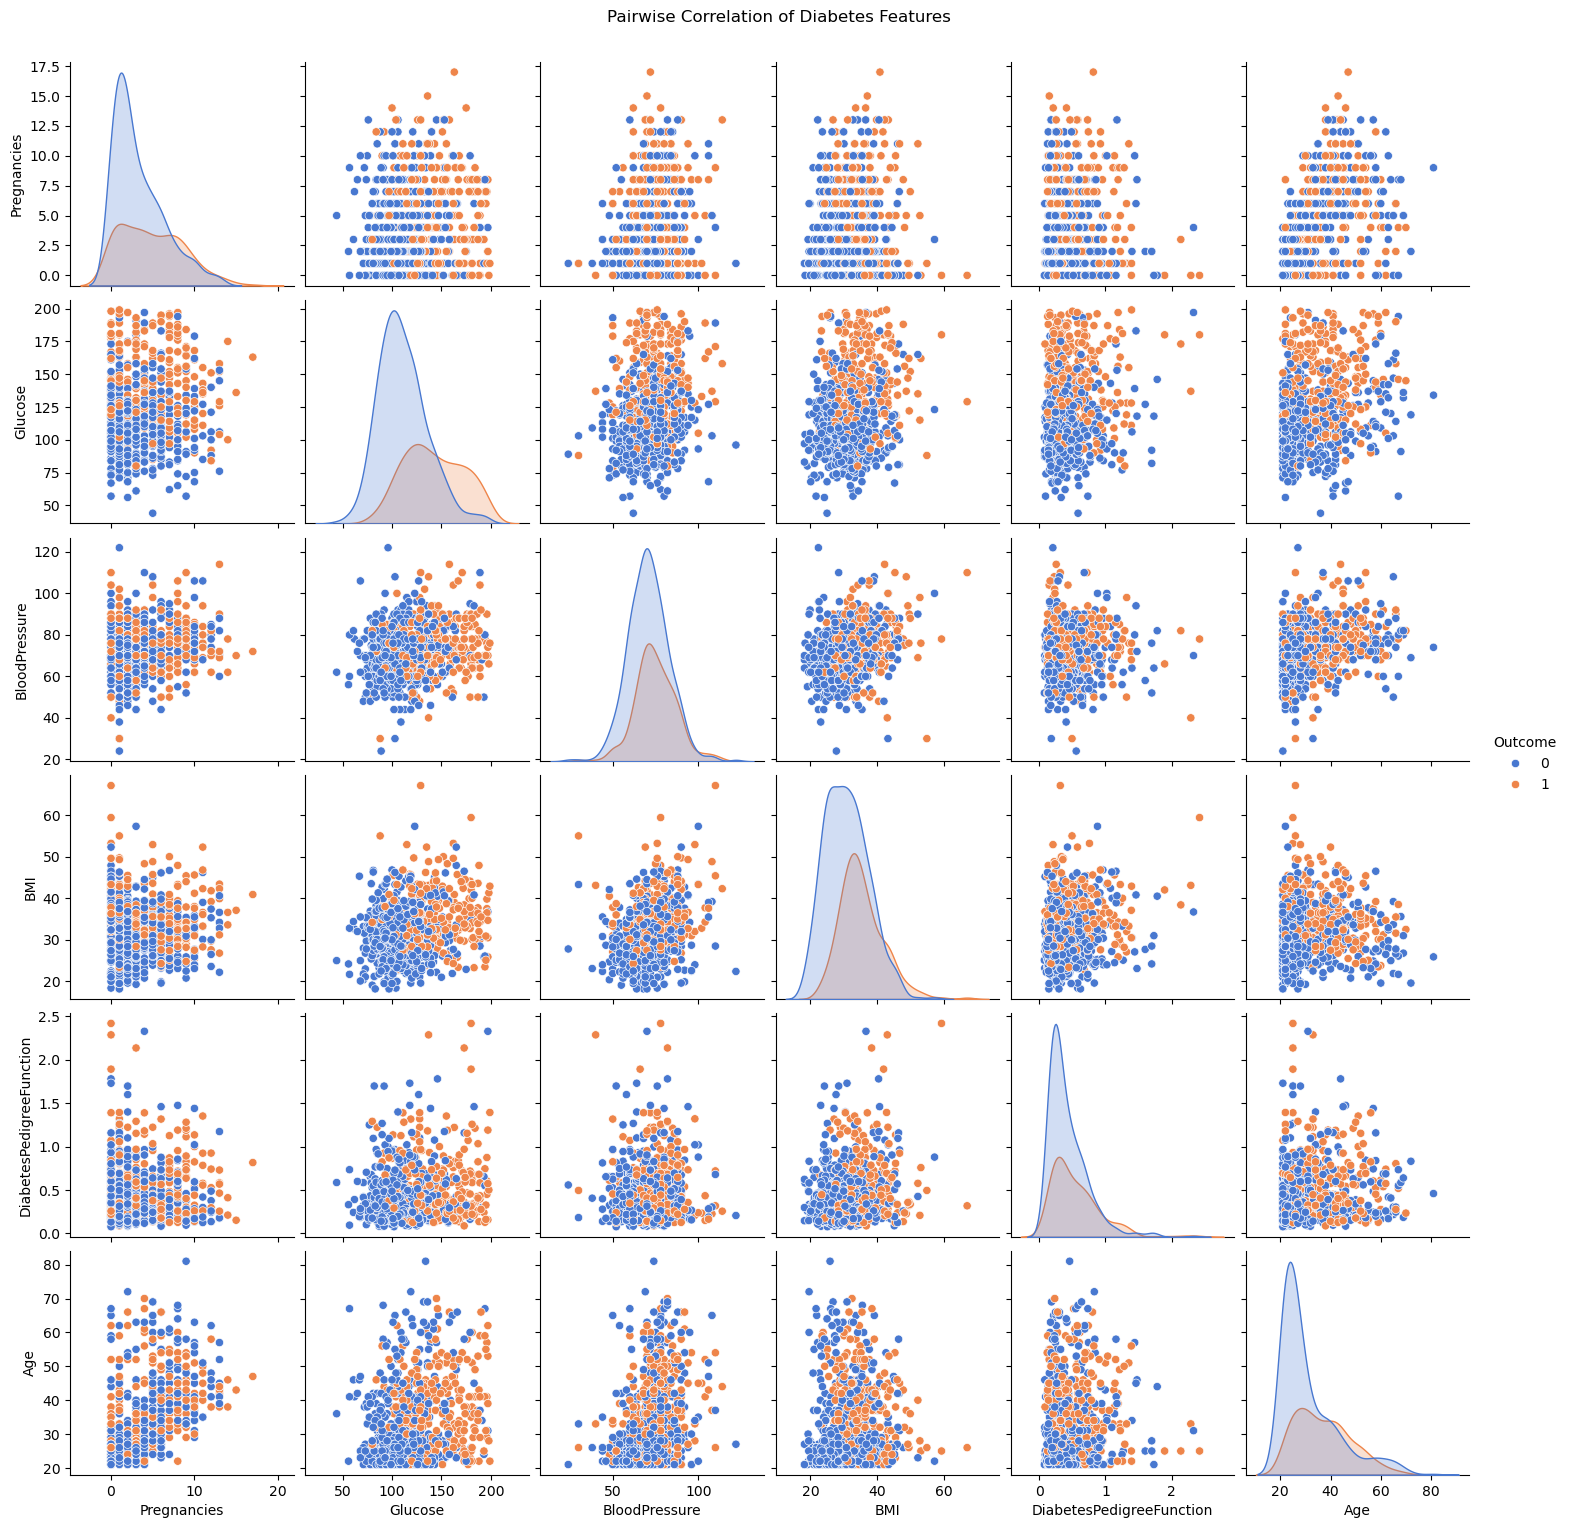

In [163]:
# Scatter plot of all features in dataset, to show correlation with outcome 

sns.pairplot(diabetes_df, hue='Outcome', diag_kind='kde', palette='muted')
plt.suptitle('Pairwise Correlation of Diabetes Features', y=1.02)
plt.show()

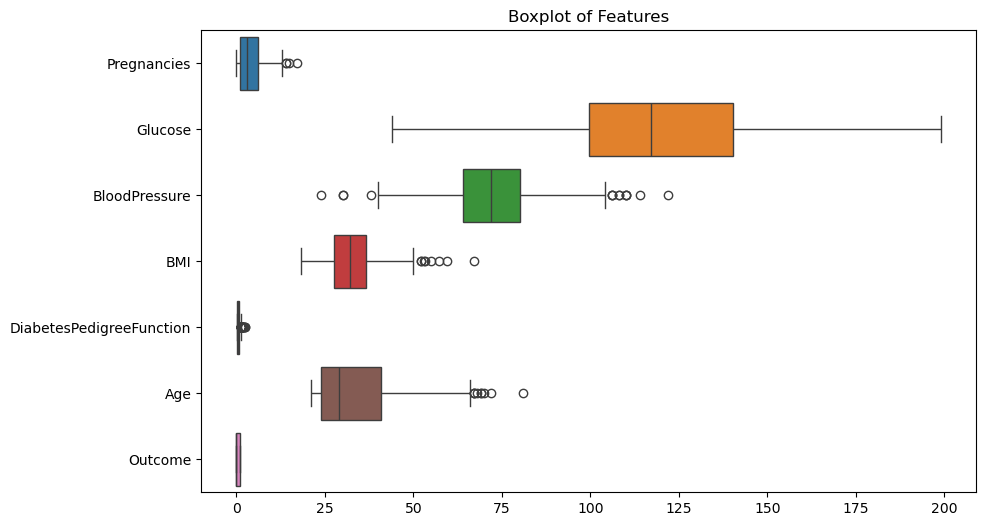

In [164]:
#Boxplot to show distribution of features 

plt.figure(figsize=(10, 6))
sns.boxplot(data=diabetes_df, orient='h')
plt.title('Boxplot of Features')
plt.show()

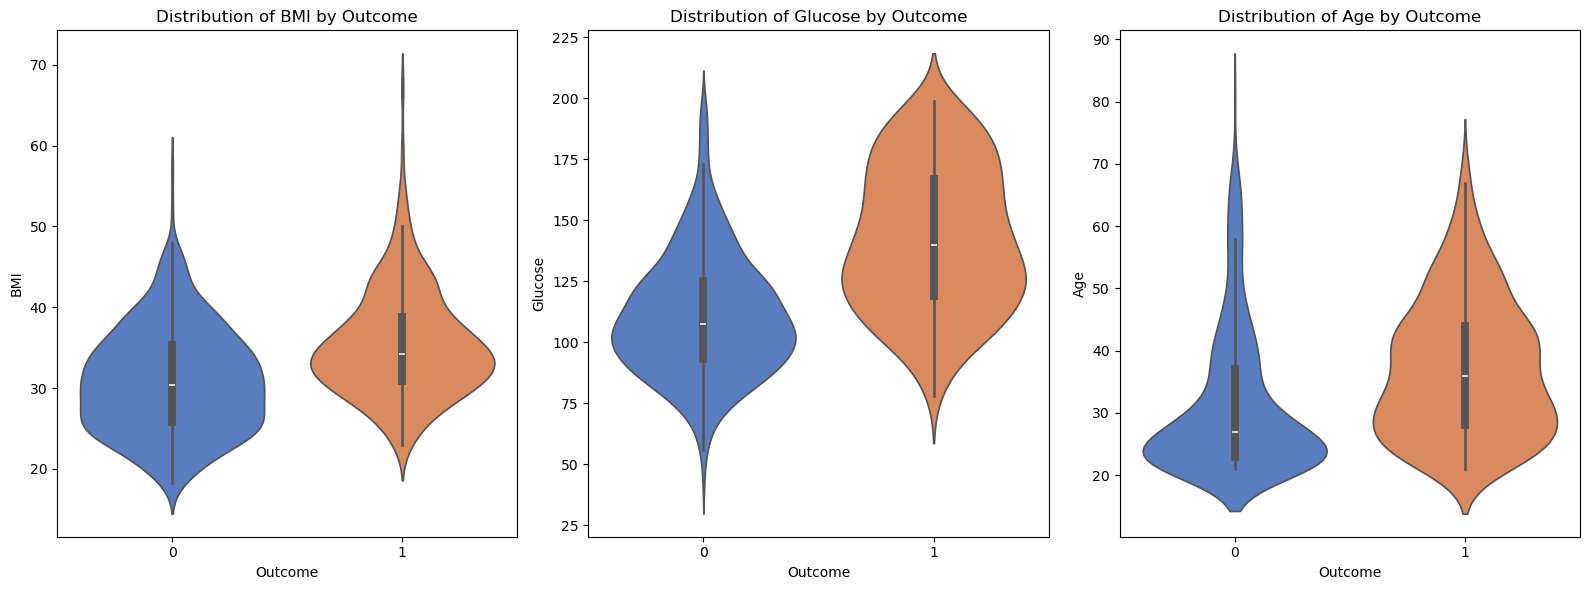

In [165]:
#Distribution of select features

plt.figure(figsize=(16, 6))

# Violin plot for BMI by Outcome
plt.subplot(1, 3, 1)
sns.violinplot(data=diabetes_df, x='Outcome', y='BMI', hue='Outcome', palette='muted', legend=False)
plt.title('Distribution of BMI by Outcome')

# Violin plot for Glucose by Outcome
plt.subplot(1, 3, 2)
sns.violinplot(data=diabetes_df, x='Outcome', y='Glucose', hue='Outcome', palette='muted', legend=False)
plt.title('Distribution of Glucose by Outcome')

# Violin plot for Age by Outcome
plt.subplot(1, 3, 3)
sns.violinplot(data=diabetes_df, x='Outcome', y='Age', hue='Outcome', palette='muted', legend=False)
plt.title('Distribution of Age by Outcome')

plt.tight_layout()
plt.show()


## Decision Tree

In [166]:
#Split by features and outcome into arrays

X = diabetes_df.iloc[:, :-1].values
y = diabetes_df.iloc[:, -1].values

In [167]:
#Split data into train/test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 6), (154, 6), (614,), (154,))

In [168]:
# K-fold Cross Validation; Searching for best CV value

best_cv = 0
best_mean_accuracy = 0

dt = DecisionTreeClassifier(random_state=2) #Import Classifer 

for cv in range(2, 11):  #Different fold numbers
    scores = cross_val_score(dt, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    print(f"CV: {cv}, Mean accuracy: {mean_accuracy}")
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_cv = cv

print(f"Best CV value: {best_cv} with mean accuracy: {best_mean_accuracy}")

CV: 2, Mean accuracy: 0.6872964169381107
CV: 3, Mean accuracy: 0.6922604814283436
CV: 4, Mean accuracy: 0.7003543841779136
CV: 5, Mean accuracy: 0.734519525523124
CV: 6, Mean accuracy: 0.7182879624341646
CV: 7, Mean accuracy: 0.7133340797133901
CV: 8, Mean accuracy: 0.723192925495557
CV: 9, Mean accuracy: 0.7297290897035142
CV: 10, Mean accuracy: 0.703437334743522
Best CV value: 5 with mean accuracy: 0.734519525523124


In [169]:
#Using Randomized Grid Search to tune hyperparameters

parameters = {
    'max_depth': range(1, 16), 
    'max_features': range(1, 6), 
    'max_leaf_nodes': range(2, 50),
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': range(2, 11)
}
dt = DecisionTreeClassifier(random_state=3) #Import Classifer 
gs = RandomizedSearchCV(dt, parameters, cv=best_cv) #Randomized search
gs.fit(X_train, y_train)

/Users/Daxtonfurniss_1/opt/anaconda3/envs/conda_clone/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=3),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(1, 16),
                                        'max_features': range(1, 6),
                                        'max_leaf_nodes': range(2, 50),
                                        'min_samples_split': range(2, 11),
                                        'splitter': ['best', 'random']})

In [170]:
gs.best_score_, gs.best_params_

(0.7655204584832733,
 {'splitter': 'best',
  'min_samples_split': 2,
  'max_leaf_nodes': 24,
  'max_features': 4,
  'max_depth': 6,
  'criterion': 'gini'})

In [171]:
#Training data and plotting confusion matrix

dt = DecisionTreeClassifier(random_state=4, 
                            max_depth=gs.best_params_['max_depth'], 
                            max_features=gs.best_params_['max_features'],
                            max_leaf_nodes=gs.best_params_['max_leaf_nodes'],
                            criterion=gs.best_params_['criterion'],
                            splitter=gs.best_params_['splitter'],
                            min_samples_split=gs.best_params_['min_samples_split']) 
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, max_features=4, max_leaf_nodes=24,
                       random_state=4)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       103
           1       0.48      0.39      0.43        51

    accuracy                           0.66       154
   macro avg       0.60      0.59      0.59       154
weighted avg       0.64      0.66      0.65       154

Confusion Matrix:


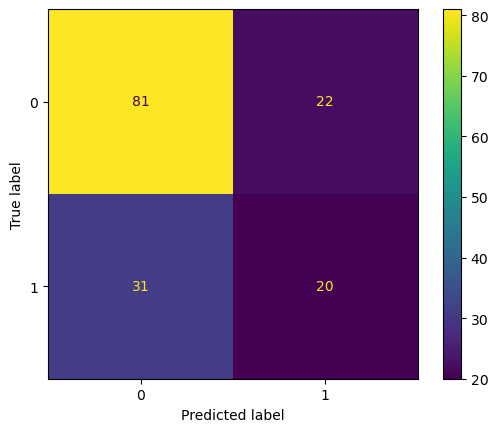

In [172]:
y_pred_gs = dt.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_gs))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

In [173]:
import optuna

# Optuna (Decision Tree Classifier)
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    cv = trial.suggest_int('cv', 2, 10)

    dt = DecisionTreeClassifier(
        random_state=22,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        splitter=splitter
    )
    
    best_score = cross_val_score(dt, X_train, y_train, cv=cv)
    return best_score.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=22))
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.params}")

# Fit the Decision Tree model with the best Optuna hyperparameters
best_params = study.best_trial.params
dt_best_optuna = DecisionTreeClassifier(
    random_state=22,
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    splitter=best_params['splitter']
)
dt_best_optuna = dt_best_optuna.fit(X_train, y_train)

[I 2024-12-01 23:16:27,825] A new study created in memory with name: no-name-f1ed295e-37b0-48fa-a3d1-8895bb300a98
[I 2024-12-01 23:16:27,855] Trial 0 finished with value: 0.7410714285714286 and parameters: {'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 9, 'criterion': 'gini', 'splitter': 'best', 'cv': 8}. Best is trial 0 with value: 0.7410714285714286.
[I 2024-12-01 23:16:27,863] Trial 1 finished with value: 0.7280130293159609 and parameters: {'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 1, 'criterion': 'entropy', 'splitter': 'best', 'cv': 2}. Best is trial 0 with value: 0.7410714285714286.
[I 2024-12-01 23:16:27,885] Trial 2 finished with value: 0.7639573070607553 and parameters: {'max_depth': 25, 'min_samples_split': 20, 'min_samples_leaf': 15, 'criterion': 'entropy', 'splitter': 'best', 'cv': 7}. Best is trial 2 with value: 0.7639573070607553.
[I 2024-12-01 23:16:27,911] Trial 3 finished with value: 0.7670976603201667 and parameters: {'max_depth': 14, 

Best trial: {'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 19, 'criterion': 'entropy', 'splitter': 'best', 'cv': 7}


Accuracy: 0.7077922077922078


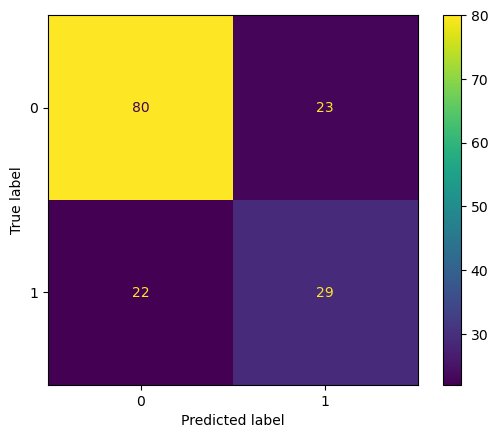

In [174]:
#Training data and plotting confusion matrix

dt_best_optuna.fit(X_train, y_train)
my.plot_confusion_matrix_with_accuracy(dt_best_optuna, X_test, y_test)

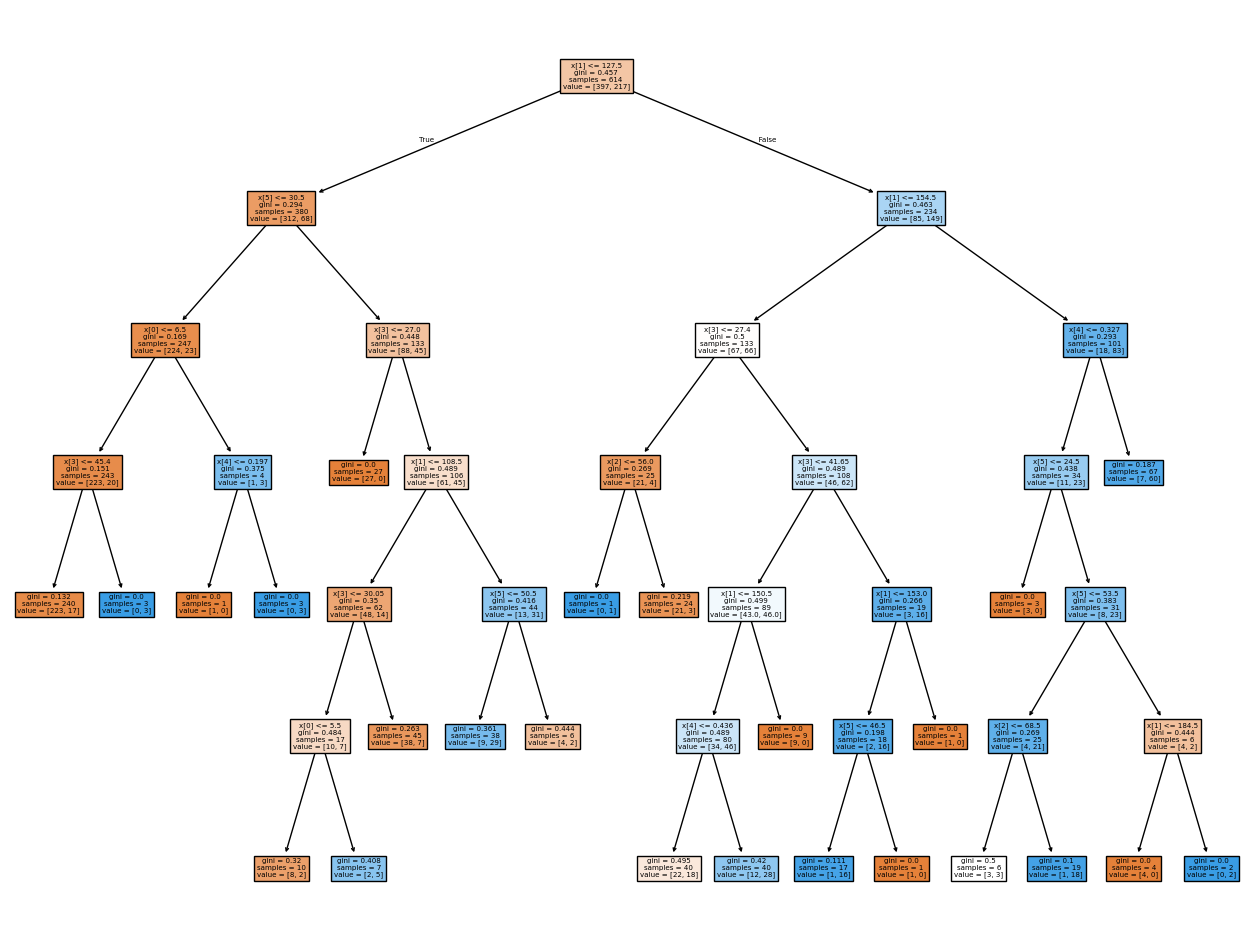

In [175]:
# Plot Decision Tree (RGS Model)

fig, ax = plt.subplots(1, 1, figsize=(16,12))
plot_tree(dt, ax=ax, filled=True)
print('')

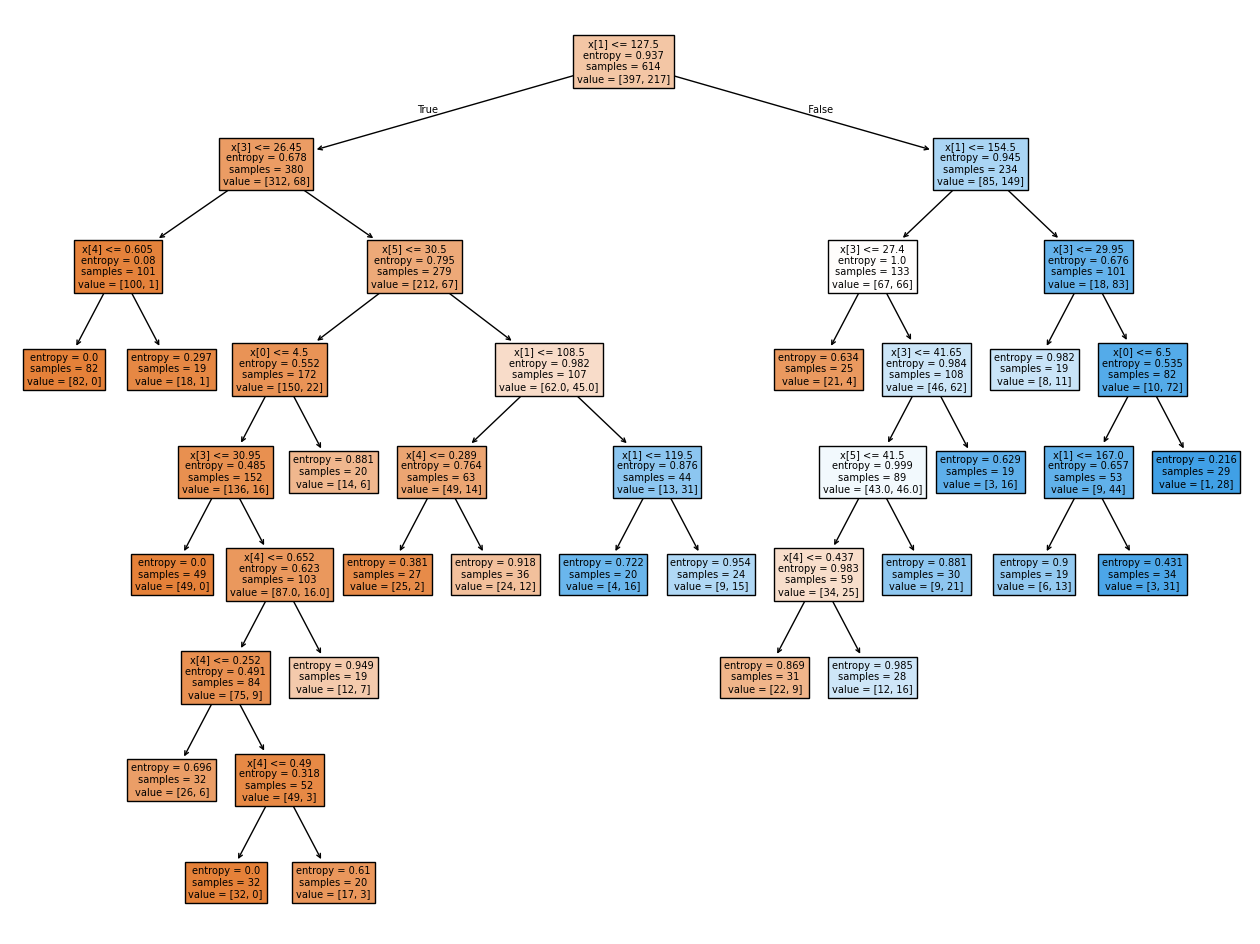

In [176]:
# Plot Decision Tree (Optuna Model)

fig, ax = plt.subplots(1, 1, figsize=(16,12))
plot_tree(dt_best_optuna, ax=ax, filled=True)
print('')

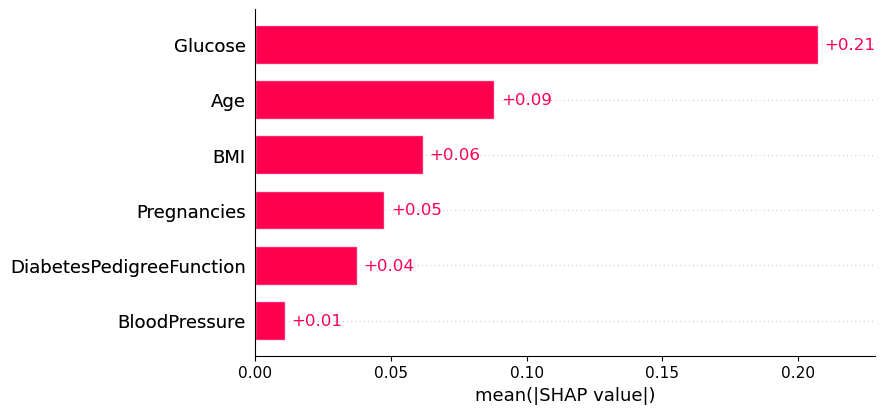

In [177]:
##SHAP
import shap
shap.initjs()
#print(shap.__version__) 0.42.1

feature_names = diabetes_df.columns[:-1]
explainer = shap.TreeExplainer(dt, feature_names=feature_names)
explanations = explainer(X_test)
shap.plots.bar(explanations[:, :, 0])


In [178]:
# shap.force_plot(explanations[:,:,0])
# shap.plots.beeswarm(explanations[:,:,0])
# shap.plots.scatter(explanations[:, [7, 1, 6], 0])

## Logistic Regression


In [179]:
#Split by features and outcome into arrays

X, y = diabetes_df.iloc[:, :-1].values, diabetes_df.iloc[:, -1].values

In [180]:
#Split data into train/test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 6), (154, 6), (614,), (154,))

In [181]:
LogisticRegression().get_params() #Showing hyperparameters

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [182]:
#Looking at params for Pipeline
make_pipeline(StandardScaler(), LogisticRegression()).get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'deprecated',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

In [183]:
#K-Means Cross Validation

best_cv = 0
best_mean_accuracy = 0

logreg = LogisticRegression(random_state=5, max_iter=1000) #Import Classifer

for cv in range(2, 11):  #Different fold numbers
    scores = cross_val_score(logreg, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    print(f"CV: {cv}, Mean accuracy: {mean_accuracy}")
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_cv = cv

print(f"Best CV value: {best_cv} with mean accuracy: {best_mean_accuracy}")

CV: 2, Mean accuracy: 0.755700325732899
CV: 3, Mean accuracy: 0.771983102183963
CV: 4, Mean accuracy: 0.7622761225702401
CV: 5, Mean accuracy: 0.7621884579501533
CV: 6, Mean accuracy: 0.768751189796307
CV: 7, Mean accuracy: 0.7654127481713688
CV: 8, Mean accuracy: 0.7687115516062886
CV: 9, Mean accuracy: 0.7703656341763758
CV: 10, Mean accuracy: 0.7639873083024854
Best CV value: 3 with mean accuracy: 0.771983102183963


In [184]:

# Define param ranges to iterate through
param_grid = {
    'logisticregression__C': np.logspace(-4, 4, 10),
    'logisticregression__max_iter': range(100, 5001),
    'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet']
}

# Valid params initiation
valid_params = {
    'logisticregression__C': [],
    'logisticregression__max_iter': [],
    'logisticregression__solver': [],
    'logisticregression__penalty': []
}

param_list = list(ParameterSampler(param_grid, n_iter=100, random_state=6))

#Searching through valid param combinations and applying to pipeline
for params in param_list:
    solver = params['logisticregression__solver']
    penalty = params['logisticregression__penalty']
    is_valid = False  # Flag to check if the combination is valid

    # Check validity based on the table
    if solver == 'lbfgs' and penalty in ['l2']:
        is_valid = True
    elif solver == 'liblinear' and penalty in ['l1', 'l2']:
        is_valid = True
    elif solver == 'newton-cg' and penalty in ['l2']:
        is_valid = True
    elif solver == 'sag' and penalty in ['l2']:
        is_valid = True
    elif solver == 'saga' and penalty in ['elasticnet', 'l1', 'l2']:
        is_valid = True

    # Append valid combinations to valid_params
    if is_valid:
        valid_params['logisticregression__C'].append(params['logisticregression__C'])
        valid_params['logisticregression__max_iter'].append(params['logisticregression__max_iter'])
        valid_params['logisticregression__solver'].append(params['logisticregression__solver'])
        valid_params['logisticregression__penalty'].append(params['logisticregression__penalty'])

valid_params

pipeline = make_pipeline(StandardScaler(), LogisticRegression(random_state=11))
gs_pipeline = RandomizedSearchCV(pipeline, param_distributions=valid_params, cv=best_cv, n_iter=50) # Randomized search
gs_pipeline = gs_pipeline.fit(X_train, y_train)


/Users/Daxtonfurniss_1/opt/anaconda3/envs/conda_clone/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
36 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/Daxtonfurniss_1/opt/anaconda3/envs/conda_clone/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Daxtonfurniss_1/opt/anaconda3/envs/conda_clone/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [185]:
#Showing best params output

gs_pipeline.best_score_, gs_pipeline.best_params_

(0.771983102183963,
 {'logisticregression__solver': 'saga',
  'logisticregression__penalty': 'l2',
  'logisticregression__max_iter': 1975,
  'logisticregression__C': 10000.0})

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       103
           1       0.66      0.61      0.63        51

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.77      0.76       154

Confusion Matrix:


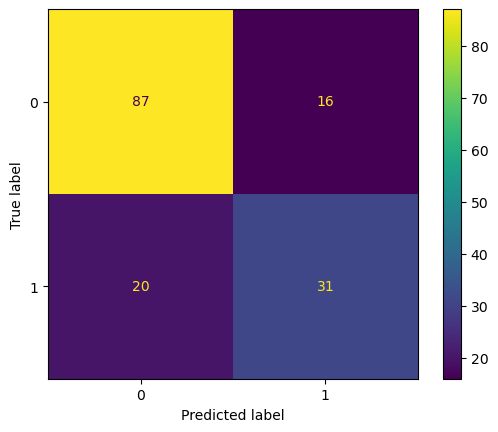

In [186]:
#Confusion matrix results for randomized search grid results

y_pred_gs = gs_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_gs))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(gs_pipeline, X_test, y_test)

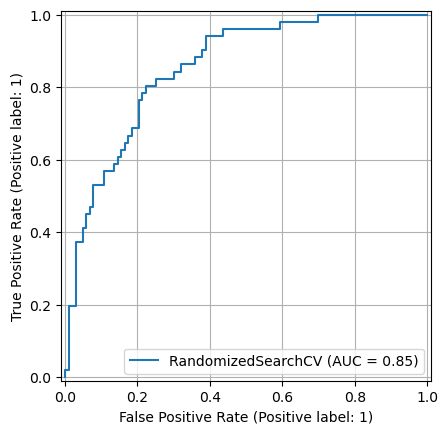

In [187]:
#ROC plot and AUC score to measure performance

RocCurveDisplay.from_estimator(gs_pipeline, X_test, y_test)
plt.grid()

In [188]:
import optuna

# Optuna (Logistic Regression)
def objective(trial):
    C = trial.suggest_float('C', 0.01, 100.0, log=False)
    max_iter = trial.suggest_int('max_iter', 100, 5000)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l2'])
    cv = trial.suggest_int('cv', 2, 10)

    logreg = LogisticRegression(
        random_state=22,
        C=C,
        max_iter=max_iter,
        solver=solver,
        penalty=penalty,
    )
    
    best_score = cross_val_score(logreg, X_train, y_train, cv=cv)
    return best_score.mean()

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=22))
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.params}")

# Fit the LogReg model with the best Optuna hyperparameters
best_params = study.best_trial.params
logreg_best_optuna = LogisticRegression(
    random_state=22,
    C=best_params['C'],
    max_iter=best_params['max_iter'],
    solver=best_params['solver'],
    penalty=best_params['penalty']
)
logreg_best_optuna = logreg_best_optuna.fit(X_train, y_train)

[I 2024-12-01 23:16:34,858] A new study created in memory with name: no-name-e1c9319a-f101-4551-bb04-f98a0f298d3a
[I 2024-12-01 23:16:34,916] Trial 0 finished with value: 0.7686901913875598 and parameters: {'C': 20.853969130510674, 'max_iter': 2460, 'solver': 'liblinear', 'penalty': 'l2', 'cv': 8}. Best is trial 0 with value: 0.7686901913875598.
[I 2024-12-01 23:16:34,937] Trial 1 finished with value: 0.754071661237785 and parameters: {'C': 22.048247618606187, 'max_iter': 4079, 'solver': 'newton-cg', 'penalty': 'l2', 'cv': 2}. Best is trial 0 with value: 0.7686901913875598.
[I 2024-12-01 23:16:35,007] Trial 2 finished with value: 0.7653940886699507 and parameters: {'C': 77.20666670573918, 'max_iter': 4794, 'solver': 'newton-cg', 'penalty': 'l2', 'cv': 7}. Best is trial 0 with value: 0.7686901913875598.
/Users/Daxtonfurniss_1/opt/anaconda3/envs/conda_clone/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ di

Best trial: {'C': 21.880854238045135, 'max_iter': 920, 'solver': 'newton-cg', 'penalty': 'l2', 'cv': 3}


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       103
           1       0.66      0.61      0.63        51

    accuracy                           0.77       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.77      0.76       154

Confusion Matrix:


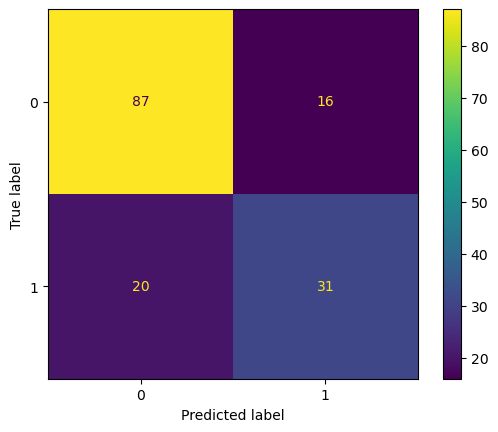

In [189]:
#Confusion matrix results for Optuna results

y_pred_optuna = logreg_best_optuna.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_optuna))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(logreg_best_optuna, X_test, y_test)


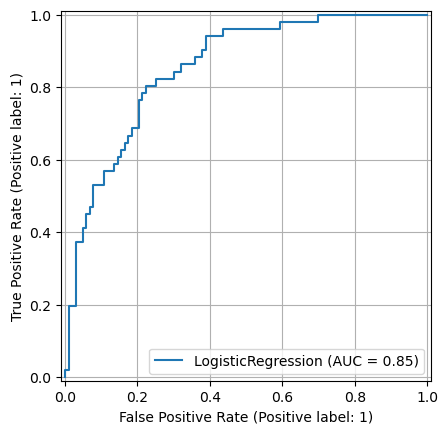

In [190]:
#ROC plot and AUC score to measure performance

RocCurveDisplay.from_estimator(logreg_best_optuna, X_test, y_test)
plt.grid()

In [191]:
#Change pipeline name to gs_pipeline to use pipeline with best params, in case need to change for SHAP

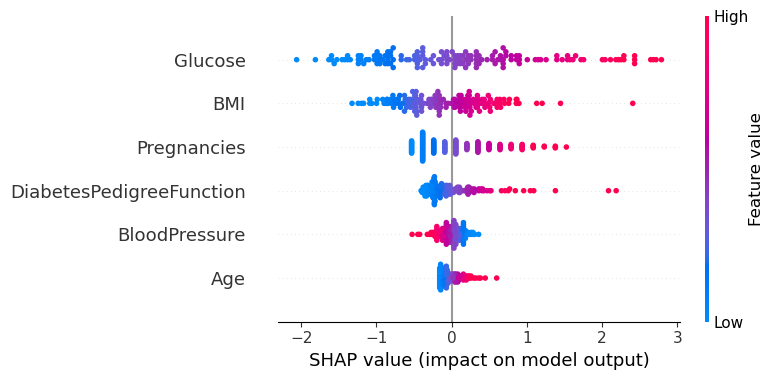

In [192]:
# Create a SHAP explainer
best_pipeline = gs_pipeline.best_estimator_
explainer = shap.Explainer(best_pipeline.named_steps['logisticregression'], best_pipeline.named_steps['standardscaler'].transform(X_train))

# Calculate SHAP values for the test data
shap_values = explainer(best_pipeline.named_steps['standardscaler'].transform(X_test))

# Convert X_test to a DataFrame if it's not already
if isinstance(X_test, np.ndarray):
    X_test_df = pd.DataFrame(X_test, columns=feature_names)  # Replace feature_names with the actual feature names
else:
    X_test_df = X_test

# Create an Explanation object
shap_explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_test_df, feature_names=X_test_df.columns)

# Plot SHAP values for a single prediction
shap.initjs()
shap.force_plot(shap_explanation[0])

# Summary plot of SHAP values for all predictions
shap.summary_plot(shap_explanation)

## Support Vector Machine (SVM)

In [193]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df.iloc[:, -1].values

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 6), (154, 6), (614,), (154,))

In [195]:
# K-fold Cross Validation; Searching for best CV value

best_cv = 0
best_mean_accuracy = 0

svm_classifier = SVC() #Import Classifer 

for cv in range(2, 11):  #Different fold numbers
    scores = cross_val_score(svm_classifier, X_train, y_train, cv=cv)
    mean_accuracy = scores.mean()
    print(f"CV: {cv}, Mean accuracy: {mean_accuracy}")
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_cv = cv

print(f"Best CV value: {best_cv} with mean accuracy: {best_mean_accuracy}")

CV: 2, Mean accuracy: 0.750814332247557
CV: 3, Mean accuracy: 0.7540411286465806
CV: 4, Mean accuracy: 0.7556659027247262
CV: 5, Mean accuracy: 0.7606424097027855
CV: 6, Mean accuracy: 0.7573291452503331
CV: 7, Mean accuracy: 0.7557098074339453
CV: 8, Mean accuracy: 0.7557245386192755
CV: 9, Mean accuracy: 0.7573411006914843
CV: 10, Mean accuracy: 0.7557112638815442
Best CV value: 5 with mean accuracy: 0.7606424097027855


In [196]:
#List hyperparameters

SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [197]:
#Viewing SVM pipeline params 

pipeline  = make_pipeline(SVC())
pipeline.get_params()

{'memory': None,
 'steps': [('svc', SVC())],
 'verbose': False,
 'svc': SVC(),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [198]:
#Using Randomized Grid Search to tune hyperparameters

parameters = {
    'svc__C': range(1, 101),    
    'svc__degree': [1, 2, 3],
    'svc__kernel': ['poly', 'linear', 'rbf', 'sigmoid']
}
svm_pipeline = make_pipeline(SVC(random_state=33))
svm_gs_pipeline = RandomizedSearchCV(svm_pipeline, parameters, cv=best_cv) #Randomized search
svm_gs_pipeline.fit(X_train, y_train)


/Users/Daxtonfurniss_1/opt/anaconda3/envs/conda_clone/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('svc', SVC(random_state=33))]),
                   param_distributions={'svc__C': range(1, 101),
                                        'svc__degree': [1, 2, 3],
                                        'svc__kernel': ['poly', 'linear', 'rbf',
                                                        'sigmoid']})

In [199]:
svm_gs_pipeline.best_score_, svm_gs_pipeline.best_params_

(0.7752632280421164, {'svc__kernel': 'linear', 'svc__degree': 1, 'svc__C': 59})

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        90
           1       0.79      0.64      0.71        64

    accuracy                           0.78       154
   macro avg       0.78      0.76      0.76       154
weighted avg       0.78      0.78      0.77       154

Confusion Matrix:


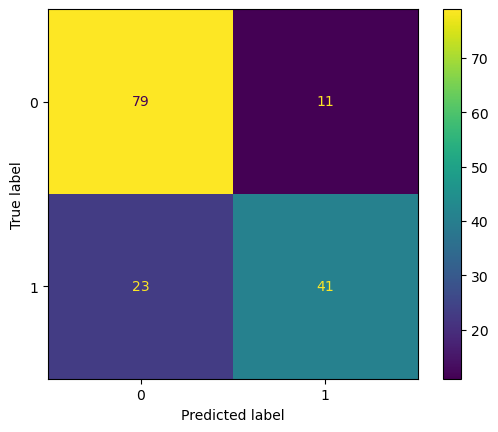

In [200]:
y_pred = svm_gs_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_estimator(svm_gs_pipeline, X_test, y_test)


In [201]:
# import optuna

# # Optuna (SVM)
# def objective(trial):
#     C = trial.suggest_loguniform('C', 1e-4, 1e3)
#     kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
#     degree = trial.suggest_int('degree', 1, 5) if kernel == 'poly' else 3
#     gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

#     svm = SVC(
#         C=C,
#         kernel=kernel,
#         degree=degree,
#         gamma=gamma,
#         random_state=42
#     )
    
#     best_score = cross_val_score(svm, X_train, y_train, cv=best_cv)
#     return best_score.mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# print(f"Best trial: {study.best_trial.params}")

# # Fit the SVM model with the best Optuna hyperparameters
# best_params = study.best_trial.params
# svm_best_optuna = SVC(
#     C=best_params['C'],
#     kernel=best_params['kernel'],
#     degree=best_params['degree'],
#     gamma=best_params['gamma'],
#     random_state=22
# )
# svm_best_optuna.fit(X_train, y_train)


Tried to run Optuna for SVM, but very computationally expensive, and takes a very long time with our dataset. We were able to get a decent accuracy score using RandomizedSearch, so not including Optuna in our pipeline, or running for comparison. 

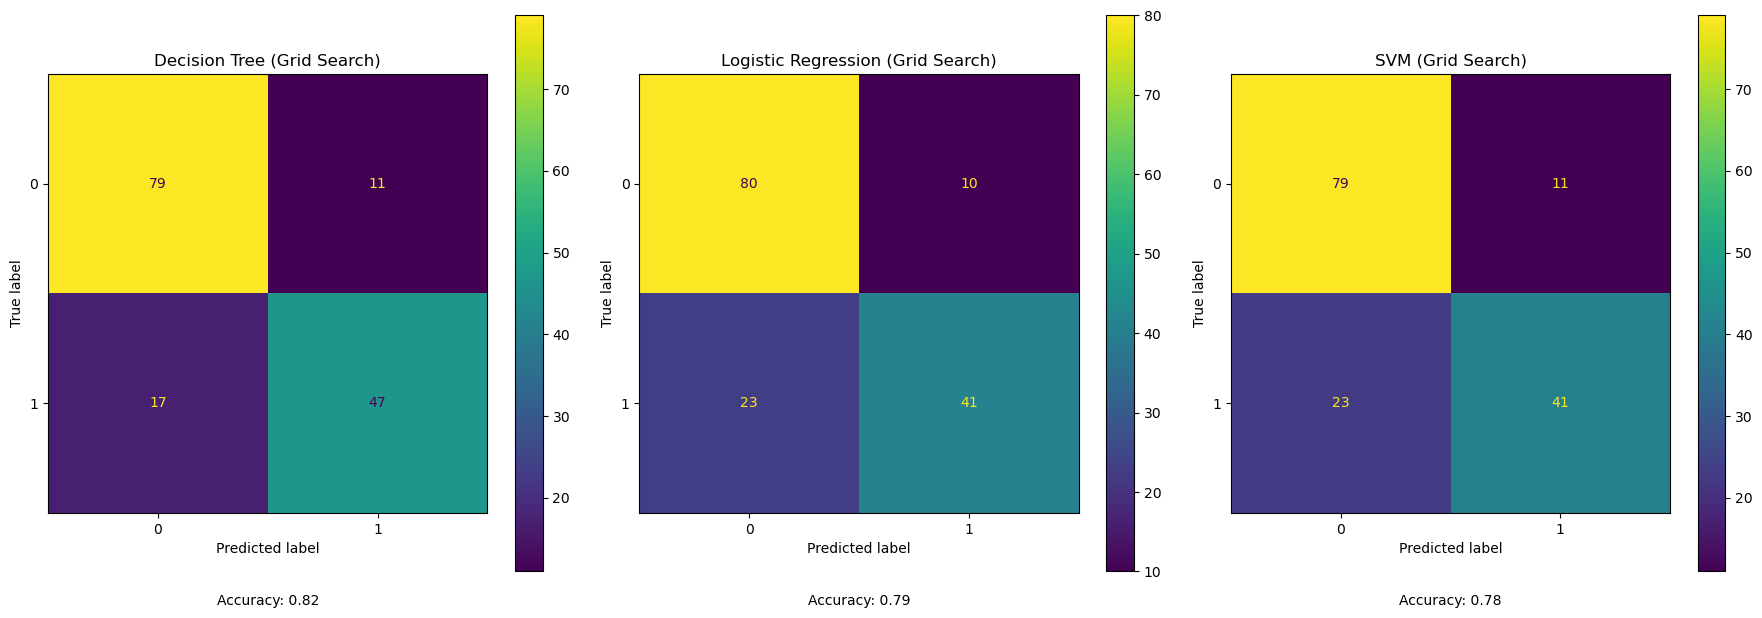

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Confusion matrix for DT
ConfusionMatrixDisplay.from_estimator(dt_best_optuna, X_test, y_test, ax=axes[0])
axes[0].set_title('Decision Tree (Grid Search)')
axes[0].text(0.5, -0.2, f'Accuracy: {accuracy_score(y_test, dt_best_optuna.predict(X_test)):.2f}', 
             ha='center', va='center', transform=axes[0].transAxes)

# Confusion matrix for LR
ConfusionMatrixDisplay.from_estimator(gs_pipeline, X_test, y_test, ax=axes[1])
axes[1].set_title('Logistic Regression (Grid Search)')
axes[1].text(0.5, -0.2, f'Accuracy: {accuracy_score(y_test, gs_pipeline.predict(X_test)):.2f}', 
             ha='center', va='center', transform=axes[1].transAxes)

# Confusion matrix for SVM
ConfusionMatrixDisplay.from_estimator(svm_gs_pipeline, X_test, y_test, ax=axes[2])
axes[2].set_title('SVM (Grid Search)')
axes[2].text(0.5, -0.2, f'Accuracy: {accuracy_score(y_test, svm_gs_pipeline.predict(X_test)):.2f}', 
             ha='center', va='center', transform=axes[2].transAxes)

plt.tight_layout()
plt.show()
